In [1]:
import datajoint as dj
dj.config.load("dj_local_conf_2.json")

import numpy as np
import pynwb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from spyglass.position import PositionOutput
import spyglass.common as sgc
import pandas as pd
from wtrack import PositionValidator, DioEventProcessor, DIOLogParser, DIOValidator, get_first_pokes_after_well_change, check_pump_after_pokes

[2026-01-07 13:53:41,407][INFO]: DataJoint is configured from /home/dmrodriguez/spyglass/notebooks/dj_local_conf_2.json
[2026-01-07 13:53:43,068][INFO]: DataJoint 0.14.6 connected to denissemorales@lmf-db.cin.ucsf.edu:3306


In [ ]:
nwb_file_name = "Emmett20251206_.nwb"

In [3]:

nwb = pynwb.NWBHDF5IO(sgc.Nwbfile().get_abs_path(nwb_file_name),'r').read()

/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
ndx-franklab-novela - cached version: 0.2.0, loaded version: 0.2.3
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
nwbf_dios = nwb.fields["processing"]["behavior"]["behavioral_events"].fields["time_series"]

In [5]:
nwbf = nwb

In [6]:
import pandas as pd

# Define the epochs you're interested in (1, 3, 5, 7, 9)
epochs_of_interest = [1, 3, 5, 7, 9]

# Initialize an empty list to store the data from selected epochs
epoch_data_list = []

# Loop through the specified epochs
for epoch_index in epochs_of_interest:
    # Extract the epoch data
    epoch_start_time, epoch_stop_time, epoch_name = nwb.intervals['epochs'][epoch_index].to_numpy()[0]

    # Append the data to the list
    epoch_data_list.append({
        'epoch_start_time': epoch_start_time,
        'epoch_stop_time': epoch_stop_time,
        'epoch_name': epoch_name
    })

# Convert the list into a DataFrame
epochs_df = pd.DataFrame(epoch_data_list)

In [7]:
#

In [8]:
# Define the epochs you're interested in (1, 3, 5, 7, 9)
epochs_of_interest = [1, 3, 5, 7, 9]

# Define the mapping for DIO events
name_mapping = {
    'LeftWell_Poke': 'Left_poke',
    'CenterWell_Poke': 'Center_poke',
    'RightWell_Poke': 'Right_poke',
    'LeftMilk_Pump': 'Left_pump',
    'CenterMilk_Pump': 'Center_pump',
    'RightMilk_Pump': 'Right_pump',
}

# Dictionary to store DIO events for each epoch
all_dio_events = {}

# Loop through the specified epochs
for epoch_index in epochs_of_interest:
    # Extract the start and stop times for the epoch
    epoch_start_time, epoch_stop_time, epoch_name = nwb.intervals['epochs'][epoch_index].to_numpy()[0]

    # Make sure epoch_name is a scalar (not a numpy.ndarray)
    epoch_name = epoch_name.item() if isinstance(epoch_name, np.ndarray) else epoch_name

    # Initialize a dictionary to store DIO events for this epoch
    dio_events = {}

    # Access the DIO data from the NWB file
    nwbf_dios = nwb.processing['behavior'].data_interfaces['behavioral_events'].time_series

    # Loop through each DIO event in the name_mapping
    for i, (nwb_name, mapped_name) in enumerate(name_mapping.items()):
        if nwb_name in nwbf_dios:
            # Get timestamps and data for the current DIO event
            ts = np.asarray(nwbf_dios[nwb_name].timestamps[:])
            data = np.asarray(nwbf_dios[nwb_name].data[:])

            # Filter the DIO events based on the epoch's start and stop times
            mask = (ts > epoch_start_time) & (ts <= epoch_stop_time)

            # Store the filtered events for this DIO
            dio_events[i] = {
                "name": mapped_name,
                "times": ts[mask],
                "values": data[mask]
            }

    # Store the DIO events for this epoch in the all_dio_events dictionary
    all_dio_events[epoch_name] = dio_events

# Now, `all_dio_events` contains the filtered DIO events for each epoch
# Example of how to access the DIO events for a specific epoch:
print(all_dio_events)  # This will print the DIO events for each epoch (1, 3, 5, 7, 9)

# Example of accessing DIO events for epoch 'Epoch_1':
# print(all_dio_events['Epoch_1'])


{'02_r1': {0: {'name': 'Left_poke', 'times': array([1.76504065e+09, 1.76504072e+09, 1.76504073e+09, 1.76504081e+09,
       1.76504082e+09, 1.76504086e+09, 1.76504086e+09, 1.76504090e+09,
       1.76504091e+09, 1.76504091e+09, 1.76504091e+09, 1.76504093e+09,
       1.76504093e+09, 1.76504094e+09, 1.76504095e+09, 1.76504098e+09,
       1.76504099e+09, 1.76504102e+09, 1.76504103e+09, 1.76504108e+09,
       1.76504110e+09, 1.76504111e+09, 1.76504111e+09, 1.76504113e+09,
       1.76504113e+09, 1.76504116e+09, 1.76504117e+09, 1.76504118e+09,
       1.76504119e+09, 1.76504122e+09, 1.76504123e+09, 1.76504127e+09,
       1.76504127e+09, 1.76504131e+09, 1.76504132e+09, 1.76504136e+09,
       1.76504137e+09, 1.76504138e+09, 1.76504138e+09, 1.76504142e+09,
       1.76504143e+09, 1.76504146e+09, 1.76504147e+09, 1.76504151e+09,
       1.76504152e+09, 1.76504152e+09, 1.76504152e+09, 1.76504153e+09,
       1.76504154e+09, 1.76504154e+09, 1.76504154e+09, 1.76504157e+09,
       1.76504158e+09, 1.7650416

In [9]:
nwbf_dios = nwb.processing['behavior'].data_interfaces['behavioral_events'].time_series

name_mapping = {
    'LeftWell_Poke': 'Left_poke',
    'CenterWell_Poke': 'Center_poke',
    'RightWell_Poke': 'Right_poke',
    'LeftMilk_Pump': 'Left_pump',
    'CenterMilk_Pump': 'Center_pump',
    'RightMilk_Pump': 'Right_pump',
}

dio_events = {}
for i, (nwb_name, mapped_name) in enumerate(name_mapping.items()):
    if nwb_name in nwbf_dios:
        ts = np.asarray(nwbf_dios[nwb_name].timestamps[:])
        data = np.asarray(nwbf_dios[nwb_name].data[:])
        mask = (ts > epoch_start_time) & (ts <= epoch_stop_time)

        dio_events[i] = {
            "name": mapped_name,
            "times": ts[mask],
            "values": data[mask]
        }

In [10]:
dio_events

{0: {'name': 'Left_poke',
  'times': array([1.76505714e+09, 1.76505721e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505722e+09, 1.76505722e+09, 1.76505722e+09,
         1.76505722e+09, 1.76505733e+09, 1.76505735e+09, 1.76505735e+09,
         1.76505735e+09, 1.76505735e+09, 1.76505735e+09, 1.76505735e+09,
         1.76505735e+09, 1.76505736e+09, 1.76505736e+09, 1.76505736e+09,
         1.76505736e+09, 1.76505736e+09, 1.76505736e+09, 1.76505736e+09,
         1.76505736e+09, 1.76505749e+09, 1.76505749e+09, 1.76505750e+09,
         1.76505

In [11]:
import pandas as pd
import numpy as np

rows = []

# Iterate over each epoch in all_dio_events
for epoch_key, epoch_data in all_dio_events.items():
    for well_id, well_data in epoch_data.items():
        well_name = well_data['name']
        times = well_data['times']
        values = well_data['values']

        # Compute the distance for each timepoint (if required, otherwise remove this logic)
        for time, value in zip(times, values):
            # In case you need to compute animal positions and distance to well (which is not provided in the current data)
            animal_x = np.nan  # Placeholder value; replace with actual calculation if available
            animal_y = np.nan  # Placeholder value; replace with actual calculation if available
            distance_to_well = np.nan  # Placeholder value; replace with actual calculation if available
            well_x = np.nan  # Placeholder value; replace with actual data if available
            well_y = np.nan  # Placeholder value; replace with actual data if available

            # Store the data for this well at this time
            rows.append({
                'time': time,
                'epoch': epoch_key,
                'well_name': well_name,
                'value': value,
                'animal_x': animal_x,
                'animal_y': animal_y,
                'distance_to_well': distance_to_well,
                'well_x': well_x,
                'well_y': well_y
            })

# Convert the rows list to a DataFrame
df = pd.DataFrame(rows)
df


,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y
0,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN
2,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
3,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN
4,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2056,1.765058e+09,10_r5,Right_pump,0,NaN,NaN,NaN,NaN,NaN
2057,1.765058e+09,10_r5,Right_pump,1,NaN,NaN,NaN,NaN,NaN
2058,1.765058e+09,10_r5,Right_pump,0,NaN,NaN,NaN,NaN,NaN
2059,1.765058e+09,10_r5,Right_pump,1,NaN,NaN,NaN,NaN,NaN


In [12]:
pump_df = df[(df['well_name']=='Left_pump') | (df['well_name']=='Right_pump') | (df['well_name']=='Center_pump')]

In [13]:
df = df[(df['well_name']=='Left_poke') | (df['well_name']=='Right_poke') | (df['well_name']=='Center_poke')]

In [14]:
df

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y
0,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN
2,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
3,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN
4,1.765041e+09,02_r1,Left_poke,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1987,1.765058e+09,10_r5,Right_poke,0,NaN,NaN,NaN,NaN,NaN
1988,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN
1989,1.765058e+09,10_r5,Right_poke,0,NaN,NaN,NaN,NaN,NaN
1990,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN


In [15]:
valid_pokes = df

In [16]:
# valid_pokes = results["valid_pokes"]

first_pokes = get_first_pokes_after_well_change(valid_pokes)

print(first_pokes[["time", "well_name"]])


             time    well_name
0    1.765041e+09  Center_poke
1    1.765041e+09    Left_poke
2    1.765041e+09  Center_poke
3    1.765041e+09   Right_poke
4    1.765041e+09  Center_poke
..            ...          ...
374  1.765058e+09  Center_poke
375  1.765058e+09   Right_poke
376  1.765058e+09  Center_poke
377  1.765058e+09    Left_poke
378  1.765058e+09  Center_poke

[379 rows x 2 columns]


In [17]:
first_pokes

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well
0,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke
2,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke
3,1.765041e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke
4,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke
...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke


In [18]:
all_dio_events

{'02_r1': {0: {'name': 'Left_poke',
   'times': array([1.76504065e+09, 1.76504072e+09, 1.76504073e+09, 1.76504081e+09,
          1.76504082e+09, 1.76504086e+09, 1.76504086e+09, 1.76504090e+09,
          1.76504091e+09, 1.76504091e+09, 1.76504091e+09, 1.76504093e+09,
          1.76504093e+09, 1.76504094e+09, 1.76504095e+09, 1.76504098e+09,
          1.76504099e+09, 1.76504102e+09, 1.76504103e+09, 1.76504108e+09,
          1.76504110e+09, 1.76504111e+09, 1.76504111e+09, 1.76504113e+09,
          1.76504113e+09, 1.76504116e+09, 1.76504117e+09, 1.76504118e+09,
          1.76504119e+09, 1.76504122e+09, 1.76504123e+09, 1.76504127e+09,
          1.76504127e+09, 1.76504131e+09, 1.76504132e+09, 1.76504136e+09,
          1.76504137e+09, 1.76504138e+09, 1.76504138e+09, 1.76504142e+09,
          1.76504143e+09, 1.76504146e+09, 1.76504147e+09, 1.76504151e+09,
          1.76504152e+09, 1.76504152e+09, 1.76504152e+09, 1.76504153e+09,
          1.76504154e+09, 1.76504154e+09, 1.76504154e+09, 1.7650415

In [19]:

#Filter name mapping to pumps only
pump_name_mapping = {k: v for k, v in name_mapping.items() if "Pump" in k}

pump_events = {}
for i, (nwb_name, mapped_name) in enumerate(pump_name_mapping.items()):
    if nwb_name in nwbf_dios:
        ts = np.asarray(nwbf_dios[nwb_name].timestamps[:])
        data = np.asarray(nwbf_dios[nwb_name].data[:])
        mask = (ts > epoch_start_time) & (ts <= epoch_stop_time)

        pump_events[i] = {
            "name": mapped_name,
            "times": ts[mask],
            "values": data[mask]
        }

pump_times_dict = {v['name']: v['times'] for v in pump_events.values()}
pump_times_dict = all

In [20]:
import numpy as np

# Create flat pump_times_dict combining all sessions
pump_times_dict = {}

for session_id, session_data in all_dio_events.items():
    for channel_id, channel_data in session_data.items():
        event_name = channel_data['name']

        # Check if this is a pump event
        if 'pump' in event_name.lower():
            times = channel_data['times']
            values = channel_data['values']

            # Only keep times where value is 1 (pump activation)
            activation_times = times[values == 1]

            # Initialize list if this pump type hasn't been seen yet
            if event_name not in pump_times_dict:
                pump_times_dict[event_name] = []

            # Add activation times to the list
            pump_times_dict[event_name].extend(activation_times)

# Convert lists to sorted numpy arrays
for pump_name in pump_times_dict:
    pump_times_dict[pump_name] = np.sort(np.array(pump_times_dict[pump_name]))

In [21]:
pump_times_dict

{'Left_pump': array([1.76504081e+09, 1.76504086e+09, 1.76504090e+09, 1.76504098e+09,
        1.76504102e+09, 1.76504108e+09, 1.76504116e+09, 1.76504122e+09,
        1.76504127e+09, 1.76504131e+09, 1.76504136e+09, 1.76504142e+09,
        1.76504146e+09, 1.76504151e+09, 1.76504157e+09, 1.76504161e+09,
        1.76504166e+09, 1.76504170e+09, 1.76504174e+09, 1.76504179e+09,
        1.76504184e+09, 1.76504485e+09, 1.76504495e+09, 1.76504500e+09,
        1.76504504e+09, 1.76504509e+09, 1.76504513e+09, 1.76504518e+09,
        1.76504523e+09, 1.76504527e+09, 1.76504533e+09, 1.76504538e+09,
        1.76504543e+09, 1.76504549e+09, 1.76504554e+09, 1.76504559e+09,
        1.76504564e+09, 1.76504568e+09, 1.76504572e+09, 1.76504578e+09,
        1.76504583e+09, 1.76504589e+09, 1.76504904e+09, 1.76504912e+09,
        1.76504920e+09, 1.76504927e+09, 1.76504934e+09, 1.76504939e+09,
        1.76504944e+09, 1.76504948e+09, 1.76504954e+09, 1.76504958e+09,
        1.76504963e+09, 1.76504968e+09, 1.76504975e

In [22]:
def flag_close_pokes(pokes_df, min_interval=10.0):
    df = pokes_df.sort_values("time").reset_index(drop=True)
    df["time_diff"] = df["time"].diff()
    df["too_close"] = df["time_diff"] < min_interval
    return df

pump_results_df = check_pump_after_pokes(
    first_pokes,
    pump_times_dict,
    max_delay=0.5  # optional, only count pumps within 0.5s of poke
)

# Initialize the 'time_between_rewards' column
pump_results_df['time_between_rewards'] = None

# Find indices of rows where a pump event triggered
pump_indices = pump_results_df[pump_results_df['pump_triggered']].index

# Ensure there's at least one pump event to process
if len(pump_indices) > 0:
    # Set the time difference for the first reward (use epoch start time)
    epoch_start_time = pump_results_df['time'].iloc[0]  # Assuming the first row contains the epoch start time
    pump_results_df.loc[pump_indices[0], 'time_between_rewards'] = (
        pump_results_df.loc[pump_indices[0], 'pump_time'] - epoch_start_time
    )

# Calculate the time difference between consecutive pump events
for i in range(1, len(pump_indices)):
    prev_idx = pump_indices[i - 1]
    curr_idx = pump_indices[i]

    # Calculate the time difference between consecutive pump events
    time_diff = pump_results_df.loc[curr_idx, 'pump_time'] - pump_results_df.loc[prev_idx, 'pump_time']

    # Set the time difference for the current event
    pump_results_df.loc[curr_idx, 'time_between_rewards'] = time_diff


In [23]:
def calculate_time_between_rewards(pump_results_df, epoch_start_time):
    """
    Calculate time between rewards, using epoch start time for the first reward.

    Parameters:
    -----------
    pump_results_df : pd.DataFrame
        DataFrame with pump results including 'pump_triggered' and 'pump_time' columns
    epoch_start_time : float
        The start time of the current epoch

    Returns:
    --------
    pd.DataFrame with 'time_between_rewards' column added
    """
    # Initialize the column
    pump_results_df['time_between_rewards'] = None

    # Find indices of rows where a pump event triggered
    pump_indices = pump_results_df[pump_results_df['pump_triggered']].index

    # Ensure there's at least one pump event to process
    if len(pump_indices) > 0:
        # Use the epoch start time for the first reward
        pump_results_df.loc[pump_indices[0], 'time_between_rewards'] = (
            pump_results_df.loc[pump_indices[0], 'pump_time'] - epoch_start_time
        )

        # Calculate the time difference between consecutive pump events
        for i in range(1, len(pump_indices)):
            prev_idx = pump_indices[i - 1]
            curr_idx = pump_indices[i]

            time_diff = pump_results_df.loc[curr_idx, 'pump_time'] - pump_results_df.loc[prev_idx, 'pump_time']
            pump_results_df.loc[curr_idx, 'time_between_rewards'] = time_diff

    return pump_results_df

In [24]:
start_time = epochs_df[epochs_df['epoch_name'] == '04_r2']['epoch_start_time'].values[0]
start_time

1765044537.412

In [25]:
def assign_trial_type(well_name):
    if well_name is None:
        return None  # or return a default value depending on your requirement
    if pd.isna(well_name):  # Check if the value is NaN or None
        return None  # Or return a default value if preferred
    if "Center" in well_name:
        return "Outbound"
    elif "Left" in well_name or "Right" in well_name:
        return "Inbound"
    else:
        return None  # In case there are any unknown well names

# Apply the function to the 'prev_well' column
pump_results_df['trial_type'] = pump_results_df['prev_well'].apply(assign_trial_type)
pump_results_df

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type
0,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.765041e+09,0.025900,0.0259,None
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound
2,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765041e+09,0.020267,45.250462,Inbound
3,1.765041e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765041e+09,0.019367,20.009208,Outbound
4,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765041e+09,0.021900,18.199793,Inbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound


In [26]:
pump_results_df

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type
0,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.765041e+09,0.025900,0.0259,None
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound
2,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765041e+09,0.020267,45.250462,Inbound
3,1.765041e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765041e+09,0.019367,20.009208,Outbound
4,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765041e+09,0.021900,18.199793,Inbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound


In [27]:
# Usage:
epoch = '06_r4'
subset_df = pump_results_df[pump_results_df['epoch'] == '10_r5']
start_time = epochs_df[epochs_df['epoch_name'] == '08_r4']['epoch_start_time'].values[0]
test = calculate_time_between_rewards(subset_df, start_time)

/tmp/ipykernel_1765439/848031763.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump_results_df['time_between_rewards'] = None


In [ ]:
test

In [ ]:
epochs_df

In [ ]:
epoch = '10_r5'

In [ ]:
# pump_results_df['time_between_rewards'] = pump_results_df['time'].diff()

# Drop the first row (NaN time difference)

subset_df = pump_results_df[pump_results_df['epoch'] == epoch]
start_time = epochs_df[epochs_df['epoch_name'] == epoch]['epoch_start_time'].values[0]
plot_df = calculate_time_between_rewards(subset_df, start_time)
plot_df = plot_df.dropna(subset=['time_between_rewards']).reset_index()

# Plot the time between poke events
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['time_between_rewards'])
plt.title('Time Between Rewards - Epoch 25', fontsize=16)
plt.xlabel('Trial Number', fontsize=14)
plt.ylabel('Time Between Rewards (s)', fontsize=14)
plt.ylim([0, 150,])
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
df_well = pump_results_df
df_well

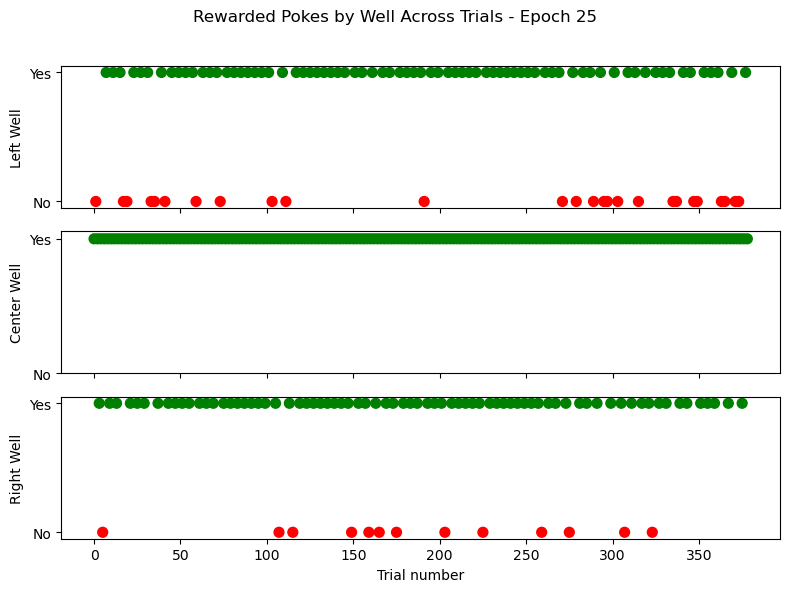

In [93]:
import matplotlib.pyplot as plt

# Map well names to simplified labels
well_labels = ["Left", "Center", "Right"]

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for ax, well in zip(axes, well_labels):
    plot_df = pump_results_df #[pump_results_df['epoch'] == epoch]
    df_well = plot_df[plot_df['well_name'].str.contains(well)]

    ax.scatter(df_well.index, df_well['pump_triggered'],
               c=df_well['pump_triggered'].map({True: 'green', False: 'red'}),
               s=50)
    ax.set_ylabel(f"{well} Well")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["No", "Yes"])
    ax.grid(False)

axes[-1].set_xlabel("Trial number")
plt.suptitle("Rewarded Pokes by Well Across Trials - Epoch 25")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [94]:
rewarded_pokes = pump_results_df[pump_results_df['pump_triggered']==True]
rewarded_pokes

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type
0,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.765041e+09,0.025900,0.0259,None
2,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765041e+09,0.020267,45.250462,Inbound
3,1.765041e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765041e+09,0.019367,20.009208,Outbound
4,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765041e+09,0.021900,18.199793,Inbound
6,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765041e+09,0.021567,19.390703,Inbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound


In [95]:
len(rewarded_pokes)

340

In [96]:
statescript_path = '/stelmo/denisse/Jacob/raw/20250618/20250618_Jacob_02_r1/20250618_Jacob_02_r1.stateScriptLog'

In [97]:
# 1. Parse your log file
parser = DIOLogParser(timestamp_scale=1000.0)  # timestamps in ms
parsed_events, reward_events = parser.parse_log_file('/stelmo/denisse/Jacob/raw/20250618/20250618_Jacob_04_r2/20250618_Jacob_04_r2.stateScriptLog')

# 2. Map DIO channels to names (based on your setup)
dio_name_map = {
    6: 'Left_poke',
    8: 'Center_poke',
    14: 'Right_poke'
}

# 3. Convert to format for your processor
dio_dict = parser.create_dio_dict(parsed_events, dio_name_map)

# 4. Process with your existing code
processor = DioEventProcessor(diff_threshold=0.001)
processed_df = processor.process_dio_events(dio_dict, verbose=False)

# 5. Validate against ground truth
validator = DIOValidator()
results = validator.compare_events(processed_df, parsed_events, tolerance=0.001)
validator.print_validation_report(results)

Stage 1: Filtering temporally close events...
Stage 2: Filtering cascading DIO events...

Filtering summary:

DIO EVENT VALIDATION REPORT

Left_poke:
----------------------------------------------------------------------
  Ground truth events: 40
  Processed events: 40
  Matched events: 40
  Match rate: 100.0%
  ✓ Perfect match!

Center_poke:
----------------------------------------------------------------------
  Ground truth events: 36
  Processed events: 36
  Matched events: 36
  Match rate: 100.0%
  ✓ Perfect match!

Right_poke:
----------------------------------------------------------------------
  Ground truth events: 30
  Processed events: 30
  Matched events: 30
  Match rate: 100.0%
  ✓ Perfect match!



In [98]:
import pandas as pd
import numpy as np

def check_pump_for_pokes(processed_df, poke_name="Left_poke", pump_name="reward_pump", window=0.5):
    """
    Check if pokes triggered the pump.

    Parameters
    ----------
    processed_df : pd.DataFrame
        Processed DIO events with columns: ['dio_name', 'dio_event_times', 'dio_event_values']
    poke_name : str
        Name of the poke to check
    pump_name : str
        Name of the pump DIO channel
    window : float
        Time window (seconds) after poke to consider pump ON as triggered

    Returns
    -------
    pd.DataFrame
        Columns: ['poke_time', 'pump_delivered', 'pump_times_after_poke']
    """

    # Extract poke times
    poke_times = processed_df[processed_df["dio_name"]==poke_name]["dio_event_times"].values
    if len(poke_times) == 0:
        return pd.DataFrame(columns=["poke_time", "pump_delivered", "pump_times_after_poke"])
    poke_times = np.concatenate(poke_times)

    # Extract pump times when it turns on (value==1)
    pump_rows = processed_df[processed_df["dio_name"]==pump_name]
    if len(pump_rows) == 0:
        pump_times = np.array([])
    else:
        pump_times = np.concatenate([
            times[np.array(values)==1]
            for times, values in zip(pump_rows["dio_event_times"], pump_rows["dio_event_values"])
        ])

    # Check for pump within window after each poke
    results = []
    for poke in poke_times:
        triggered_times = pump_times[(pump_times >= poke) & (pump_times <= poke + window)]
        results.append({
            "poke_time": poke,
            "pump_delivered": len(triggered_times) > 0,
            "pump_times_after_poke": triggered_times.tolist()
        })

    return pd.DataFrame(results)


In [99]:
pump_results_df = check_pump_for_pokes(first_pokes, poke_name="Left_poke", pump_name="reward_pump", window=0.5)
print(pump_results_df)


KeyError: 'dio_name'

In [3]:
from AS_EM_module import EM_main, RunEM


In [249]:
pump_results_df['resp'] = pump_results_df['pump_triggered'].astype(int)

In [250]:
pump_results_df['rat_name'] = 'Emmett'

In [251]:
pump_results_df_5 = pump_results_df

In [253]:
pump_results_df_4

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name
0,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.764961e+09,0.021767,0.021767,None,1,Emmett
1,1.764961e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764961e+09,0.021867,30.62082,Outbound,1,Emmett
2,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764961e+09,0.024234,20.200122,Inbound,1,Emmett
3,1.764961e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764961e+09,0.025300,17.548064,Outbound,1,Emmett
4,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764961e+09,0.024600,20.082288,Inbound,1,Emmett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,1.764978e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764978e+09,0.023633,28.630156,Inbound,1,Emmett
353,1.764978e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764978e+09,0.020800,14.438263,Outbound,1,Emmett
354,1.764978e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764978e+09,0.023567,16.651216,Inbound,1,Emmett
355,1.764978e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764978e+09,0.024600,15.050535,Outbound,1,Emmett


In [288]:
outbound = pump_results_df[pump_results_df['trial_type']=='Inbound'].reset_index()
outbound

,index,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,2,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764707e+09,0.023167,26.230778,Inbound,1,Emmett,1
1,4,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764707e+09,0.022067,20.329946,Inbound,1,Emmett,1
2,6,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764707e+09,0.018800,21.909787,Inbound,1,Emmett,1
3,8,1.764710e+09,04_r2,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764710e+09,0.022634,2741.486995,Inbound,1,Emmett,2
4,10,1.764710e+09,04_r2,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764710e+09,0.019034,59.988947,Inbound,1,Emmett,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,370,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.026734,22.761879,Inbound,1,Emmett,25
570,372,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.028001,40.029002,Inbound,1,Emmett,25
571,374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound,1,Emmett,25
572,376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound,1,Emmett,25


In [289]:
trial = outbound[(outbound['epoch_number']>22) & (outbound['epoch_number']<24)]
trial

,index,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
489,210,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765049e+09,0.018567,25.860876,Inbound,1,Emmett,23
490,212,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765049e+09,0.026500,15.430358,Inbound,1,Emmett,23
491,214,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765049e+09,0.020600,24.058628,Inbound,1,Emmett,23
492,216,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765049e+09,0.024734,27.280654,Inbound,1,Emmett,23
493,218,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765049e+09,0.025934,25.017969,Inbound,1,Emmett,23
494,220,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765049e+09,0.021167,10.267717,Inbound,1,Emmett,23
495,222,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765049e+09,0.025367,22.131546,Inbound,1,Emmett,23
496,224,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765049e+09,0.025834,10.388584,Inbound,1,Emmett,23
497,226,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765049e+09,0.018567,17.250773,Inbound,1,Emmett,23
498,228,1.765049e+09,06_r3,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765049e+09,0.024500,17.081038,Inbound,1,Emmett,23


In [6]:
pump_results_df

,Unnamed: 0.1,Unnamed: 0,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,0,0,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,Emmett,1
1,1,1,1.764707e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.019100,142.292218,Outbound,1,Emmett,1
2,2,2,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764707e+09,0.023167,26.230778,Inbound,1,Emmett,1
3,3,3,1.764707e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.027667,58.609623,Outbound,1,Emmett,1
4,4,4,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764707e+09,0.022067,20.329946,Inbound,1,Emmett,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,1138,374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound,1,Emmett,25
1139,1139,375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.092160,Outbound,1,Emmett,25
1140,1140,376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound,1,Emmett,25
1141,1141,377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound,1,Emmett,25


In [ ]:
outbound.iloc[273, :]

In [ ]:
pump_results_df = pd.concat([pump_results_df_1, pump_results_df_2, pump_results_df_3, pump_results_df_4, pump_results_df_5])
pump_results_df

In [4]:
# pump_results_df.to_csv('emmett_wtrack.csv')
pump_results_df = pd.read_csv('emmett_wtrack.csv')

In [ ]:
pump_results_df

In [ ]:
pump_results_df = pump_results_df[
    (pump_results_df["epoch_number"] < 18)
    # (pump_results_df["epoch_number"] < 22)
].copy()

# pump_results_df = on_time

sigma2e (fixed): 0.0025000000000000005
sigma2e (fixed): 0.0025000000000000005


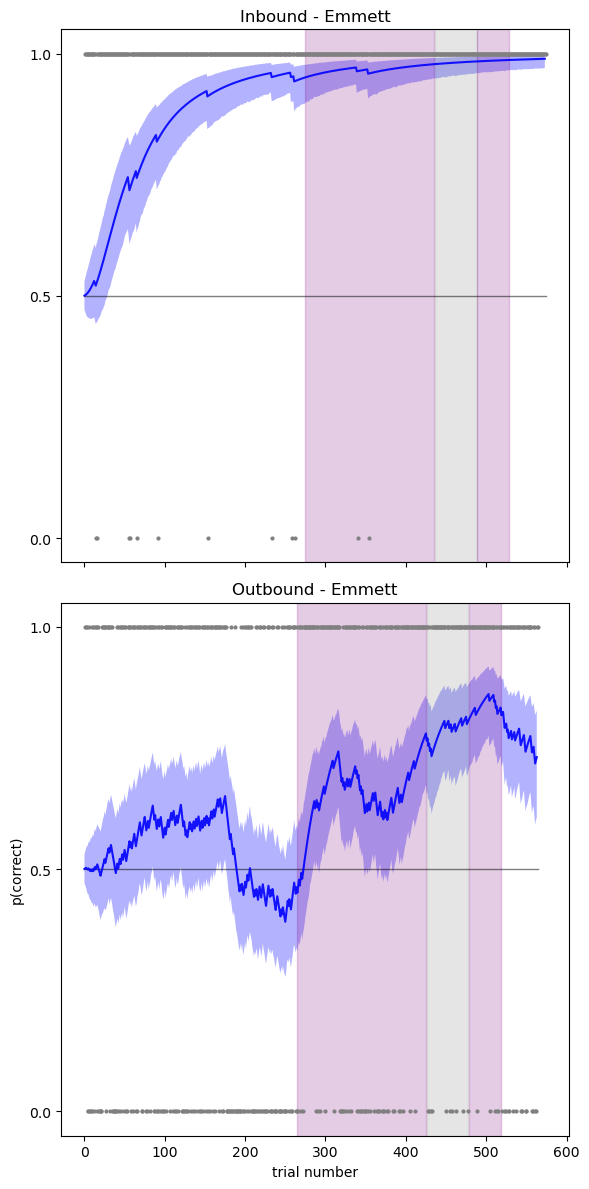

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define p_init and subplot dimensions
p_init = 0.5
subplot_width = 6
subplot_height = 6

# Set the animal you want to plot
rat_name = 'Emmett'  # Replace with the specific rat's name
trial_types = ['Inbound', 'Outbound']  # Replace with your actual trial types

# Initialize figure
num_columns = 1  # Single animal, so one column
num_rows = len(trial_types)  # Number of trial types
fig, axes = plt.subplots(
    num_rows,
    num_columns,
    figsize=(subplot_width * num_columns, subplot_height * num_rows),
    sharex=True,
    sharey=True,
)

# Plot learning curves
data_list = []

# Loop over trial types and optogenetic conditions for the selected rat
for trial_type_idx, trial_type in enumerate(trial_types):
    # Filter the DataFrame for the specific rat and trial_type
    filtered_df = pump_results_df[(pump_results_df['rat_name'] == rat_name) & (pump_results_df['trial_type'] == trial_type)].reset_index(drop=True)

    if filtered_df.empty:
        continue

    # Extract response values and trial numbers
    resp_values = filtered_df['resp']
    trial_number = filtered_df.index

    if len(resp_values) == 0:
        continue

    # Set the figure and axis for plotting
    fig_ax_list = [fig, axes[trial_type_idx]]  # Adjusted for one animal (axes is now 1D)

    # Call the main plotting function (EM_main) and get the plot elements
    fig, ax, pll, pul, pmode = EM_main(
        resp_values,
        p_init,
        fig_ax_list,
        color='blue',
        trial_number=trial_number,
    )

    # Store results for later use (data for learning trials)
    data_list.append((rat_name, trial_type, pll, trial_number, pmode))

    # Set the title and axis labels
    ax.set_title(f"{trial_type} - {rat_name}")  # Title for each subplot (Trial Type + Rat Name)
    ylabel = "p(correct)" if trial_type_idx == len(trial_types) - 1 else ""
    xlabel = "trial number" if trial_type_idx == len(trial_types) - 1 else ""
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

# Adjust layout to avoid overlap
fig.tight_layout()

axes[0].axvspan(274, 435, color='purple', alpha=0.2)
axes[0].axvspan(436, 488, color='gray', alpha=0.2)
axes[0].axvspan(489, 528, color='purple', alpha=0.2)
axes[1].axvspan(265, 425, color='purple', alpha=0.2)
axes[1].axvspan(426, 478, color='gray', alpha=0.2)
axes[1].axvspan(479, 519, color='purple', alpha=0.2)

# Add learning trials to the dataframe
def get_first_entry_else_nan(x):
    return x[0] if len(x) > 0 else np.nan

df = pd.DataFrame(data_list, columns=["rat_name", "trial_type", "pll", "trial_number", "pmode"])

# Now you can index it correctly. For example:
pll_df = df[["rat_name", "trial_type", "pll", "trial_number", "pmode"]]

learning_trials = [get_first_entry_else_nan(np.where(pll > 0.5)[0]) for pll in pll_df.pll]

def indxVal_else_nan(values, indx):
    return values[indx] if indx is not np.nan else np.nan

# Create the learning_trial column
learning_trials = [indxVal_else_nan(trial_number, ind) for trial_number, ind in zip(pll_df.trial_number, learning_trials)]
pll_df["learning_trial"] = learning_trials

# Show legend

# axes[0].legend(loc='lower right', t/itle='optogenetics')

# Optionally, display the plot
plt.show()


In [286]:
learning_trials

[0, 66]

In [ ]:
incorrect = pump_results_df[pump_results_df['pump_triggered']==False]
center_incorrect = incorrect[incorrect['well_name']=='Center_poke']
center_incorrect

In [ ]:
twelve = pump_results_df.iloc[300:310,:]#[pump_results_df['epoch_number']==13]
twelve

In [ ]:
test = pump_results_df.reset_i

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,False,NaN,NaN,None,None,0,Emmett,1
1,1.764707e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.019100,142.292218,Outbound,1,Emmett,1
2,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764707e+09,0.023167,26.230778,Inbound,1,Emmett,1
3,1.764707e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.027667,58.609623,Outbound,1,Emmett,1
4,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764707e+09,0.022067,20.329946,Inbound,1,Emmett,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound,1,Emmett,25
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound,1,Emmett,25
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound,1,Emmett,25
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound,1,Emmett,25


In [ ]:
pump_results_df_18 = pump_results_df

In [254]:
mapping = {
    '02_r1': 1,
    '04_r2': 2,
    '06_r3': 3,
    '08_r4': 4,
    '10_r5': 5
}

pump_results_df_1['epoch_number'] = pump_results_df_1['epoch'].map(mapping)


In [ ]:
pump_results_df_1

In [255]:
mapping = {
    '02_r1': 6,
    '04_r2': 7,
    '06_r3': 8,
    '08_r4': 9,
    '10_r5': 10
}

pump_results_df_2['epoch_number'] = pump_results_df_2['epoch'].map(mapping)

pump_results_df_2

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.764789e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.764789e+09,0.020767,0.020767,None,1,Emmett,6
1,1.764789e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764789e+09,0.023500,95.268419,Outbound,1,Emmett,6
2,1.764789e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764789e+09,0.028000,62.770529,Inbound,1,Emmett,6
3,1.764789e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764789e+09,0.026333,73.940562,Outbound,1,Emmett,6
4,1.764789e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764789e+09,0.021734,115.678136,Inbound,1,Emmett,6
5,1.764789e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound,0,Emmett,6
6,1.764789e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764789e+09,0.025033,88.541459,Inbound,1,Emmett,6
7,1.764789e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764789e+09,0.019133,86.678309,Outbound,1,Emmett,6
8,1.764789e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764789e+09,0.028400,31.542016,Inbound,1,Emmett,6
9,1.764789e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764789e+09,0.019267,74.12013,Outbound,1,Emmett,6


In [256]:
mapping = {
    '02_r1': 11,
    '04_r2': 12,
    '06_r3': 13,
    '08_r4': 14,
    '10_r5': 15
}

pump_results_df_3['epoch_number'] = pump_results_df_3['epoch'].map(mapping)

pump_results_df_3

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.764877e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,None,False,NaN,NaN,None,None,0,Emmett,11
1,1.764877e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,False,NaN,NaN,None,Inbound,0,Emmett,11
2,1.764877e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,False,NaN,NaN,None,Inbound,0,Emmett,11
3,1.764877e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764877e+09,0.025834,88.274375,Inbound,1,Emmett,11
4,1.764877e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764877e+09,0.020267,55.401786,Outbound,1,Emmett,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,1.764893e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764893e+09,0.022300,19.69943,Inbound,1,Emmett,15
293,1.764893e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound,0,Emmett,15
294,1.764893e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764893e+09,0.021100,28.610686,Inbound,1,Emmett,15
295,1.764893e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound,0,Emmett,15


In [257]:
mapping = {
    '02_r1': 16,
    '04_r2': 17,
    '06_r3': 18,
    '08_r4': 19,
    '10_r5': 20
}

pump_results_df_4['epoch_number'] = pump_results_df_4['epoch'].map(mapping)

pump_results_df_4

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.764961e+09,0.021767,0.021767,None,1,Emmett,16
1,1.764961e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764961e+09,0.021867,30.62082,Outbound,1,Emmett,16
2,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764961e+09,0.024234,20.200122,Inbound,1,Emmett,16
3,1.764961e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764961e+09,0.025300,17.548064,Outbound,1,Emmett,16
4,1.764961e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764961e+09,0.024600,20.082288,Inbound,1,Emmett,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,1.764978e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764978e+09,0.023633,28.630156,Inbound,1,Emmett,20
353,1.764978e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764978e+09,0.020800,14.438263,Outbound,1,Emmett,20
354,1.764978e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764978e+09,0.023567,16.651216,Inbound,1,Emmett,20
355,1.764978e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764978e+09,0.024600,15.050535,Outbound,1,Emmett,20


In [258]:
mapping = {
    '02_r1': 21,
    '04_r2': 22,
    '06_r3': 23,
    '08_r4': 24,
    '10_r5': 25
}

pump_results_df_5['epoch_number'] = pump_results_df_5['epoch'].map(mapping)

pump_results_df_5

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,True,1.765041e+09,0.025900,0.0259,None,1,Emmett,21
1,1.765041e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,False,NaN,NaN,None,Outbound,0,Emmett,21
2,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765041e+09,0.020267,45.250462,Inbound,1,Emmett,21
3,1.765041e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765041e+09,0.019367,20.009208,Outbound,1,Emmett,21
4,1.765041e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765041e+09,0.021900,18.199793,Inbound,1,Emmett,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound,1,Emmett,25
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound,1,Emmett,25
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound,1,Emmett,25
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound,1,Emmett,25


In [259]:
pump_results_df = pd.concat([pump_results_df_1, pump_results_df_2, pump_results_df_3, pump_results_df_4, pump_results_df_5])
pump_results_df

,time,epoch,well_name,value,animal_x,animal_y,distance_to_well,well_x,well_y,prev_well,pump_triggered,pump_time,pump_delay,time_between_rewards,trial_type,resp,rat_name,epoch_number
0,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,None,False,NaN,NaN,None,None,0,Emmett,1
1,1.764707e+09,02_r1,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.019100,142.292218,Outbound,1,Emmett,1
2,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.764707e+09,0.023167,26.230778,Inbound,1,Emmett,1
3,1.764707e+09,02_r1,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.764707e+09,0.027667,58.609623,Outbound,1,Emmett,1
4,1.764707e+09,02_r1,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.764707e+09,0.022067,20.329946,Inbound,1,Emmett,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Left_poke,True,1.765058e+09,0.024667,69.975918,Inbound,1,Emmett,25
375,1.765058e+09,10_r5,Right_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021001,42.09216,Outbound,1,Emmett,25
376,1.765058e+09,10_r5,Center_poke,1,NaN,NaN,NaN,NaN,NaN,Right_poke,True,1.765058e+09,0.022768,16.408299,Inbound,1,Emmett,25
377,1.765058e+09,10_r5,Left_poke,1,NaN,NaN,NaN,NaN,NaN,Center_poke,True,1.765058e+09,0.021467,26.822727,Outbound,1,Emmett,25


In [ ]:
n_inbound

In [ ]:
pump_results_df[pump_results_df['epoch_number']==6]

In [ ]:
inbound_rewards

In [159]:
df = pump_results_df.copy()

# group by epoch_number
group = df.groupby("epoch_number")

# ----------------------------------------
# Trial counts (denominator)
# ----------------------------------------
inbound_trials = group.apply(lambda g: (g["trial_type"] == "Inbound").sum())
outbound_trials = group.apply(lambda g: (g["trial_type"] == "Outbound").sum())

# ----------------------------------------
# Reward counts (using resp column)
# ----------------------------------------
inbound_rewards = group.apply(lambda g: g[(g["trial_type"] == "Inbound")]["resp"].sum())
outbound_rewards = group.apply(lambda g: g[(g["trial_type"] == "Outbound")]["resp"].sum())

# ----------------------------------------
# Reward rate = proportion correct
# ----------------------------------------
inbound_reward_rate = inbound_rewards / inbound_trials.replace(0, pd.NA)
outbound_reward_rate = outbound_rewards / outbound_trials.replace(0, pd.NA)

# ----------------------------------------
# Total reward rate (all trials)
# ----------------------------------------
total_rewards = group["resp"].sum()
total_trials = group["resp"].count()
total_reward_rate = total_rewards / total_trials

# Build summary dataframe
summary = pd.DataFrame({
    "inbound_trials": inbound_trials,
    "outbound_trials": outbound_trials,
    "inbound_rewards": inbound_rewards,
    "outbound_rewards": outbound_rewards,
    "inbound_reward_rate": inbound_reward_rate,
    "outbound_reward_rate": outbound_reward_rate,
    "total_reward_rate": total_reward_rate,
    "total_rewards": total_rewards
})

summary = summary.reset_index()


/tmp/ipykernel_1177755/3136005328.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inbound_trials = group.apply(lambda g: (g["trial_type"] == "Inbound").sum())
/tmp/ipykernel_1177755/3136005328.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outbound_trials = group.apply(lambda g: (g["trial_type"] == "Outbound").sum())
/tmp/ipykernel_1177755/3136005328.py:15: DeprecationWarning: DataFrameGroupBy.app

In [1]:
summary

NameError: name 'summary' is not defined

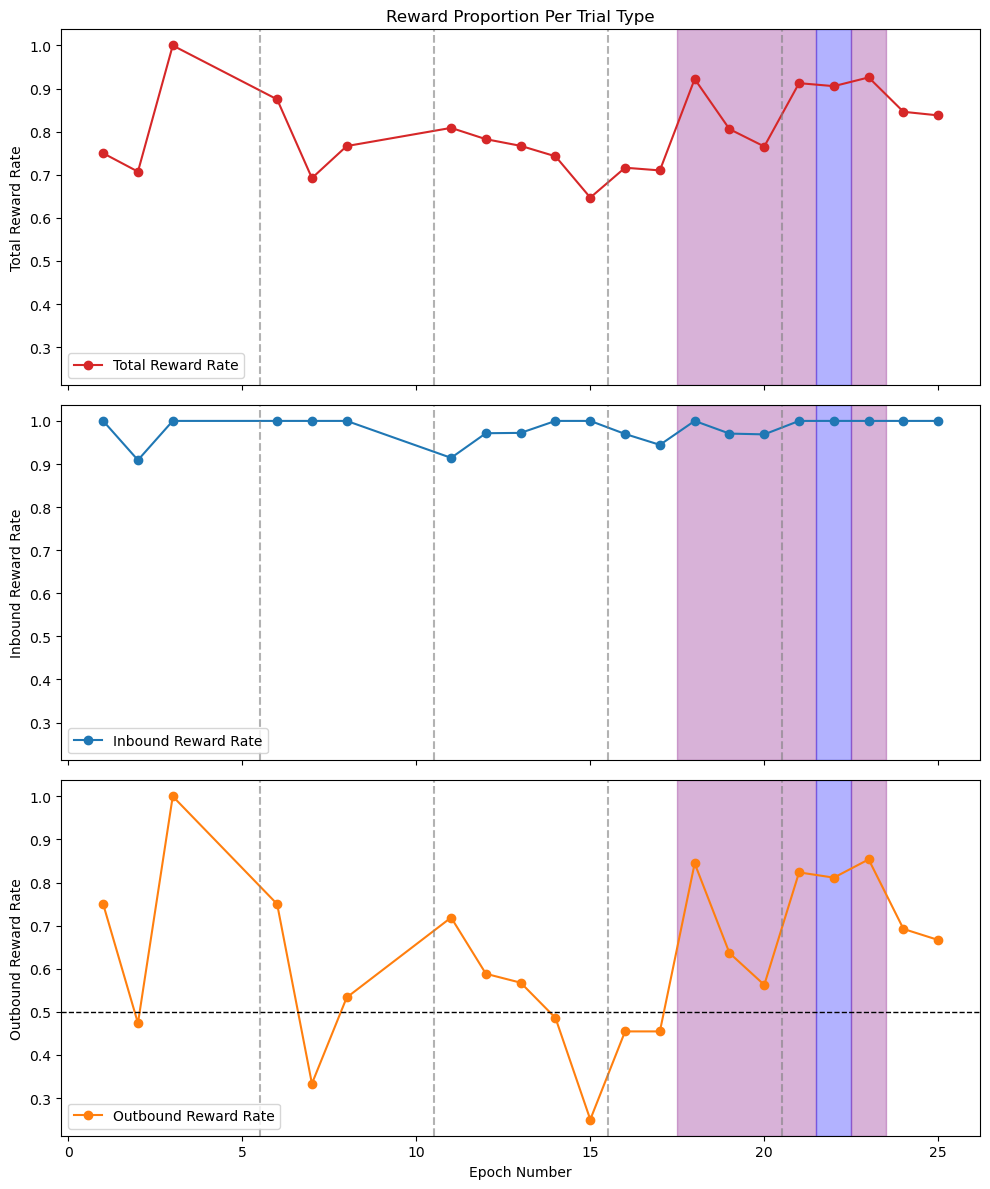

In [161]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)

# Total reward rate
axes[0].plot(summary['epoch_number'], summary["total_reward_rate"], marker='o', color='tab:red', label="Total Reward Rate")
axes[0].set_ylabel("Total Reward Rate")
axes[0].set_title("Reward Proportion Per Trial Type")
axes[0].legend()
axes[0].grid(False)
axes[0].axvspan(17.5, 21.5, color='purple', alpha=0.3)
axes[0].axvspan(21.5, 22.5, color='blue', alpha=0.3)
axes[0].axvspan(22.5, 23.5, color='purple', alpha=0.3)
axes[0].axvline(5.5, linestyle='--', color='gray', alpha=0.6)
axes[0].axvline(10.5, linestyle='--', color='gray', alpha=0.6)
axes[0].axvline(15.5, linestyle='--', color='gray', alpha=0.6)
axes[0].axvline(20.5, linestyle='--', color='gray', alpha=0.6)

# Inbound reward rate
axes[1].plot(summary['epoch_number'], summary["inbound_reward_rate"], marker='o', color='tab:blue', label="Inbound Reward Rate")
axes[1].set_ylabel("Inbound Reward Rate")
axes[1].legend()
axes[1].grid(False)
axes[1].axvspan(17.5, 21.5, color='purple', alpha=0.3)
axes[1].axvspan(21.5, 22.5, color='blue', alpha=0.3)
axes[1].axvspan(22.5, 23.5, color='purple', alpha=0.3)
axes[1].axvline(5.5, linestyle='--', color='gray', alpha=0.6)
axes[1].axvline(10.5, linestyle='--', color='gray', alpha=0.6)
axes[1].axvline(15.5, linestyle='--', color='gray', alpha=0.6)
axes[1].axvline(20.5, linestyle='--', color='gray', alpha=0.6)

# Outbound reward rate
axes[2].plot(summary['epoch_number'], summary["outbound_reward_rate"], marker='o', color='tab:orange', label="Outbound Reward Rate")
axes[2].set_ylabel("Outbound Reward Rate")
axes[2].set_xlabel("Epoch Number")
axes[2].legend()
axes[2].grid(False)
axes[2].axvspan(17.5, 21.5, color='purple', alpha=0.3)
axes[2].axvspan(21.5, 22.5, color='blue', alpha=0.3)
axes[2].axvspan(22.5, 23.5, color='purple', alpha=0.3)
axes[2].axhline(0.5, color='black', linestyle='--', linewidth=1)
axes[2].axvline(5.5, linestyle='--', color='gray', alpha=0.6)
axes[2].axvline(10.5, linestyle='--', color='gray', alpha=0.6)
axes[2].axvline(15.5, linestyle='--', color='gray', alpha=0.6)
axes[2].axvline(20.5, linestyle='--', color='gray', alpha=0.6)

x_vals = summary['epoch_number']

plt.tight_layout()
plt.show()


In [164]:
summary

,epoch_number,inbound_trials,outbound_trials,inbound_rewards,outbound_rewards,inbound_reward_rate,outbound_reward_rate,total_reward_rate,total_rewards
0,1,3,4,3,3,1.000000,0.750000,0.750000,6
1,2,22,19,20,9,0.909091,0.473684,0.707317,29
2,3,1,1,1,1,1.000000,1.000000,1.000000,2
3,6,7,8,7,6,1.000000,0.750000,0.875000,14
4,7,7,6,7,2,1.000000,0.333333,0.692308,9
5,8,15,15,15,8,1.000000,0.533333,0.766667,23
6,11,35,32,32,23,0.914286,0.718750,0.808824,55
7,12,35,34,34,20,0.971429,0.588235,0.782609,54
8,13,36,37,35,21,0.972222,0.567568,0.767123,56
9,14,35,35,35,17,1.000000,0.485714,0.742857,52


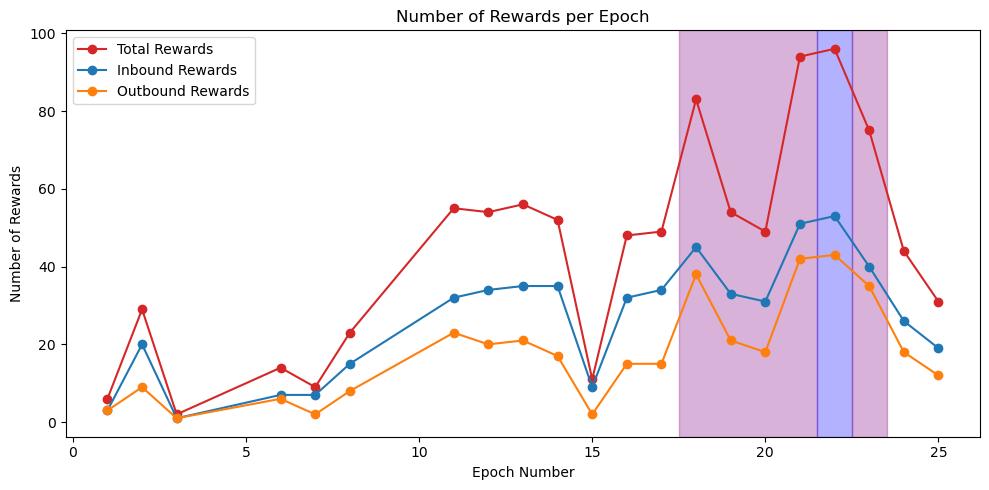

In [165]:
import matplotlib.pyplot as plt

sessions = summary['epoch_number']  # epoch_number

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(sessions, summary["total_rewards"],
        marker='o', color='tab:red', label="Total Rewards")

ax.plot(sessions, summary["inbound_rewards"],
        marker='o', color='tab:blue', label="Inbound Rewards")

ax.plot(sessions, summary["outbound_rewards"],
        marker='o', color='tab:orange', label="Outbound Rewards")

ax.set_ylabel("Number of Rewards")
ax.set_xlabel("Epoch Number")
ax.set_title("Number of Rewards per Epoch")
ax.legend()
ax.grid(False)
ax.axvspan(17.5, 21.5, color='purple', alpha=0.3)
ax.axvspan(21.5, 22.5, color='blue', alpha=0.3)
ax.axvspan(22.5, 23.5, color='purple', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

df = pump_results_df.copy()

# -----------------------------
# Compute reward-related metrics
# -----------------------------

# Total rewards per epoch
reward_summary = df.groupby("epoch_number").agg(
    total_rewards = ("value", "sum"),
    inbound_rewards = ("value", lambda x: df.loc[x.index][df.loc[x.index]["trial_type"]=="center"]["value"].sum()),
    outbound_rewards = ("value", lambda x: df.loc[x.index][df.loc[x.index]["trial_type"].isin(["left","right"]) ]["value"].sum()),
    total_pokes = ("value", "count"),
)

# Reward rates
reward_summary["reward_rate"] = reward_summary["total_rewards"] / reward_summary["total_pokes"]
reward_summary["inbound_reward_rate"] = reward_summary["inbound_rewards"] / reward_summary["total_pokes"]
reward_summary["outbound_reward_rate"] = reward_summary["outbound_rewards"] / reward_summary["total_pokes"]

sessions = reward_summary.index

# ======================
# --- Subplot section ---
# ======================
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)

# Overall reward rate
axes[0].plot(sessions, reward_summary["reward_rate"], marker='o', color='tab:red', label="Total Reward Rate")
axes[0].set_ylabel("Total Reward Rate")
axes[0].set_title("Reward/Pokes")
axes[0].legend()
axes[0].grid(False)
axes[0].axvspan(13.5, 15, color='blue', alpha=0.3)

# Inbound reward rate
axes[1].plot(sessions, reward_summary["inbound_reward_rate"], marker='o', color='tab:blue', label="Inbound Reward Rate")
axes[1].set_ylabel("Inbound Reward/Pokes")
axes[1].legend()
axes[1].grid(False)
axes[1].axvspan(13.5, 15, color='blue', alpha=0.3)

# Outbound reward rate
axes[2].plot(sessions, reward_summary["outbound_reward_rate"], marker='o', color='tab:orange', label="Outbound Reward Rate")
axes[2].set_ylabel("Outbound Reward/Pokes")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(False)
axes[2].axvspan(13.5, 15, color='blue', alpha=0.3)

plt.tight_layout()
plt.show()


# ============================
# --- Number of Rewards Plot ---
# ============================
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(sessions, reward_summary["total_rewards"], marker='o', color='tab:red', label="Total Rewards")
ax.plot(sessions, reward_summary["inbound_rewards"], marker='o', color='tab:blue', label="Inbound Rewards")
ax.plot(sessions, reward_summary["outbound_rewards"], marker='o', color='tab:orange', label="Outbound Rewards")

ax.set_ylabel("Number of Rewards")
ax.set_xlabel("Epoch")
ax.set_title("Number of Rewards per Epoch")
ax.legend()
ax.grid(False)
ax.axvspan(13.5, 15, color='blue', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
means = pump_results_df.groupby('epoch_number')['resp'].mean()
means

In [ ]:
total = pump_results_df.groupby('epoch_number')['resp'].sum
total()

In [ ]:
trials = pump_results_df.reset_index()
trials

In [ ]:
filtered_df.iloc[268,:]

In [ ]:
pump_results_df

In [ ]:
trials[trials.index ==268 ]

In [ ]:
pll_df

In [ ]:
import datajoint as dj
dj.config.load("dj_local_conf_2.json")

import numpy as np
import pynwb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from spyglass.position import PositionOutput
import spyglass.common as sgc
import pandas as pd
from wtrack import PositionValidator, DioEventProcessor, DIOLogParser, DIOValidator, get_first_pokes_after_well_change, check_pump_after_pokes
from wtrack_tables_dmr import WTrackParams, WTrackSelection, WTrackEvents

In [ ]:
WTrackParams().insert_default()

In [ ]:
WTrackParams()

In [ ]:
print(WTrackParams().fetch('event_name_map'))

In [ ]:
nwb_file_name = 'Jacob20250618_.nwb'

In [ ]:
from spyglass.position import PositionOutput
import pandas as pd
pos_key = {
    "nwb_file_name": nwb_file_name,
    "epoch": 2,
    "project_name": "w-track_Jacob"
}
merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

In [ ]:
WTrackSelection().insert1(
                          {'wtrack_params_name': 'default',
                           'nwb_file_name': 'Jacob20250618_.nwb',
                           'pos_merge_id': merge_id,
                           'epoch': 2,
                           'statescript_path': '/stelmo/denisse/Jacob/raw/20250618/20250618_Jacob_02_r1/20250618_Jacob_02_r1.stateScriptLog'}, skip_duplicates = True)


In [ ]:
WTrackSelection()

In [ ]:

key = {'wtrack_params_name': 'default',
                           'nwb_file_name': 'Jacob20250618_.nwb',
                           'pos_merge_id': merge_id,
                           'epoch': 2,
                           'statescript_path': '/stelmo/denisse/Jacob/raw/20250618/20250618_Jacob_02_r1/20250618_Jacob_02_r1.stateScriptLog'}

In [ ]:
WTrackEvents().populate(key)

In [ ]:
key

In [ ]:
(WTrackEvents() & key).fetch1_dataframe(key)

In [ ]:
(WTrackEvents() & key).fetch('validation_report')

In [ ]:
(WTrackEvents() & key).fetch('n_events')

In [ ]:
(WTrackEvents() & key).fetch_dataframe()